In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = '/Users/meetpatel/Downloads/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


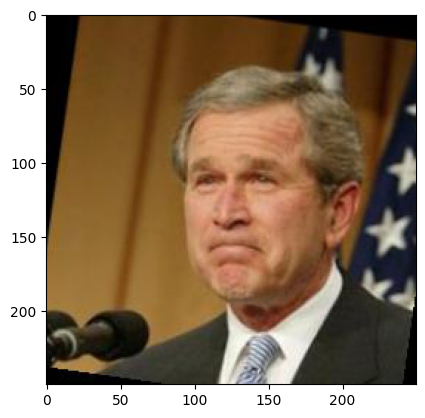

In [37]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Sample Shape: torch.Size([3, 250, 250])


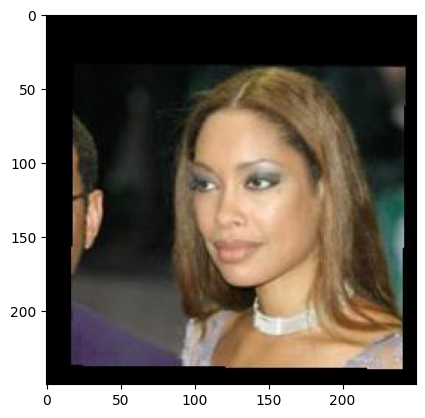

In [39]:
import matplotlib.pyplot as plt

# Get one batch of data
images, _ = next(iter(dataloader))  
sample = images[0]

# Print the shape of the sample
print("Sample Shape:", sample.shape)

# plotting the image in the batch
image_to_plot = sample.permute(1, 2, 0)  
plt.imshow(image_to_plot)
plt.show()


The dimensions of the image tensor can be explained as follows:

1. First Dimension (Channels) - 3:
The first dimension, with a size of 3, indicates that the image has three color channels (Red, Green, and Blue), typical for RGB images.

2. Second Dimension (Height) - 250:
This dimension represents the height of the image in pixels.

3. Third Dimension (Width) - 250:
This dimension represents the width of the image in pixels.

So, each image in the dataset is 250 pixels tall and 250 pixels wide

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [7]:
import torch.nn.functional as F

class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()
        # Initialize encoder layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(64)

        # Initialize decoder layers
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_bn1 = nn.BatchNorm2d(32)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        return x

    def decoder(self, x):
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = torch.sigmoid(self.dec_conv3(x))  # Using sigmoid to ensure output is between 0 and 1
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [8]:
model = AE()

In [9]:
image = images[0].unsqueeze(0)  

In [10]:
# Pass through the entire model
output = model(image)
print("Output Shape (Entire Model):", output.shape)

# Pass through the encoder and decoder separately
encoded = model.encoder(image)
print("Encoded Shape:", encoded.shape)

decoded = model.decoder(encoded)
print("Decoded Shape:", decoded.shape)


Output Shape (Entire Model): torch.Size([1, 3, 250, 250])
Encoded Shape: torch.Size([1, 64, 32, 32])
Decoded Shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
# Calculating total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 85347


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [13]:
loss_function = torch.nn.MSELoss()

I used Mean squared error as loss function, Because of its efficiency in measuring the difference between original and rebuilt images, the Mean Squared Error (MSE) loss function is usually used in autoencoder models for image reconstruction tasks. Since MSE determines the average squared difference between the actual and predicted pixel values, it is extremely sensitive to big errors and guarantees that the model's goal is to minimize these disparities. This quality is especially useful for preserving the visual integrity of rebuilt images. 

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [14]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = model.to(device)

for images, _ in dataloader:
    images = images.to(device)  # Explicitly moving data to the MPS device

In [15]:
num_epochs = 10  #number of epochs

for epoch in range(num_epochs):
    total_loss = 0

    for images, _ in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.0090
Epoch [2/10], Loss: 0.0042
Epoch [3/10], Loss: 0.0038
Epoch [4/10], Loss: 0.0036
Epoch [5/10], Loss: 0.0035
Epoch [6/10], Loss: 0.0035
Epoch [7/10], Loss: 0.0033
Epoch [8/10], Loss: 0.0032
Epoch [9/10], Loss: 0.0032
Epoch [10/10], Loss: 0.0031


When I noticed the loss wasn't dropping in my neural network training, I made a few simple but effective changes. First, I adjusted the learning rate to find a sweet spot where the model learns fast but doesn't miss important details. Then, I played around with the batch size, trying different amounts to see what worked best. I also tweaked the model itself by changing the number and types of layers to better fit my data. These small changes really helped improve my model's learning process.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

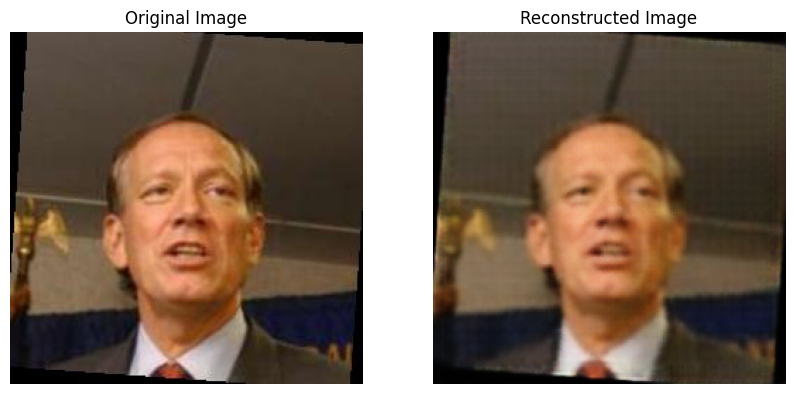

In [31]:
# Setting the model to evaluation mode
model.eval()


images, _ = next(iter(dataloader))  
original_image = images[0]  # Selecting the first image in the batch

# Adding a batch dimension and move the image to the same device as the model
input_image = original_image.unsqueeze(0).to(next(model.parameters()).device)


with torch.no_grad():
    reconstructed_image = model(input_image)

# Converting tensors to numpy arrays for plotting
# Detaching and moving tensors back to CPU for conversion to numpy arrays
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()


# Plotting figure
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

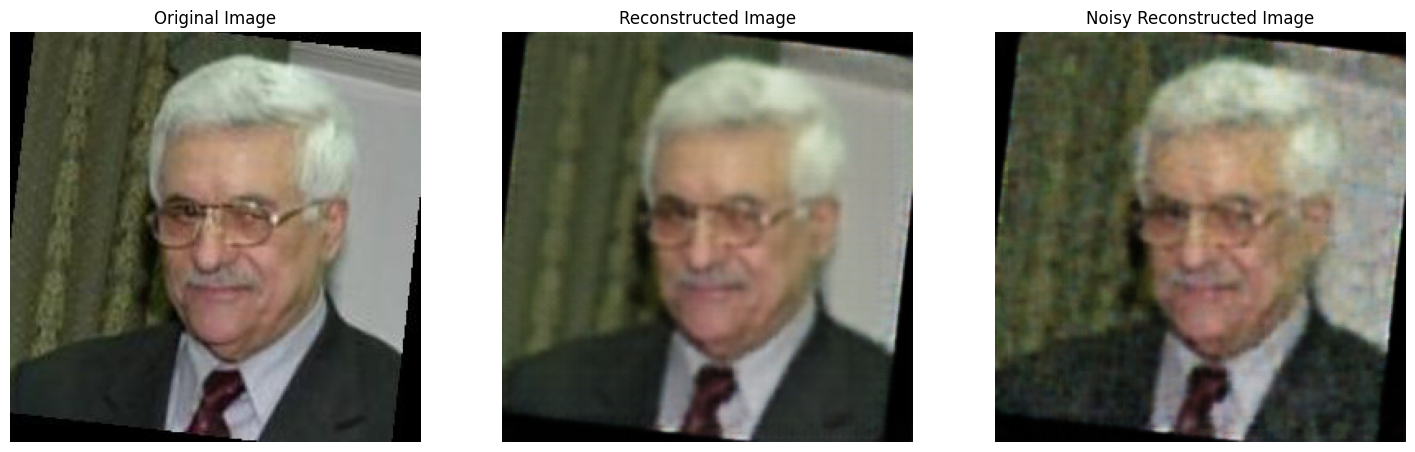

In [36]:
# Setting the model to evaluation mode
model.eval()

# Fetch a random batch of images and select the first image
images, _ = next(iter(dataloader))
original_image = images[0]

# Add a batch dimension and move the image to the same device as the model
input_image = original_image.unsqueeze(0).to(next(model.parameters()).device)

# Encode the image
with torch.no_grad():
    encoded_image = model.encoder(input_image)

# Add normally distributed noise to the encoded image
noise = torch.randn_like(encoded_image) * 0.20  
noisy_encoded_image = encoded_image + noise

# Decode both the original and noisy encoded images
reconstructed_image = model.decoder(encoded_image)
noisy_reconstructed_image = model.decoder(noisy_encoded_image)

# Move tensors back to CPU for conversion to numpy arrays and detach them from the computation graph
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
noisy_reconstructed_image_np = noisy_reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

# Plotting
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

# Noisy Reconstructed Image
plt.subplot(1, 3, 3)
plt.title("Noisy Reconstructed Image")
plt.imshow(noisy_reconstructed_image_np)
plt.axis('off')

plt.show()

I think the effects I saw on the reconstructed image when I added noise to the latent representation of an image in my autoencoder and then decoded it are quite telling about the properties of the model. In essence, this procedure assisted me in determining how resilient my model is to disturbances. The model has successfully learned to capture the important features if it is still able to reconstruct the original image rather well in spite of the additional noise. I saw that the noise affected the quality of the reconstructed image, causing some distortion or blurring. 

In [18]:
#citation:
#Chatgpt